In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import itertools

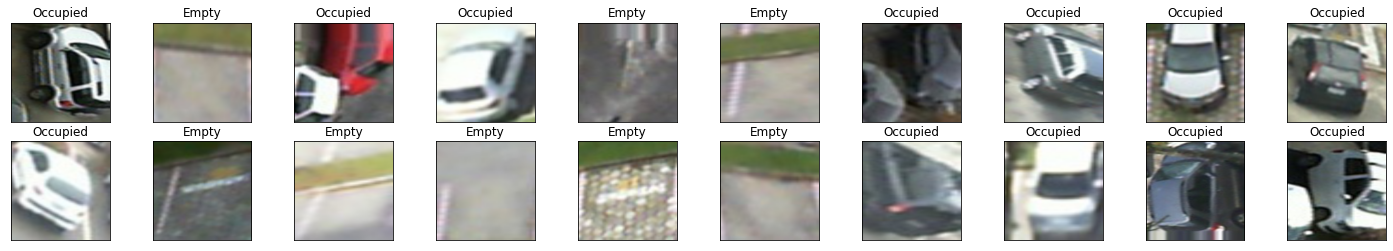

In [2]:
# location on Google Drive
test_p = './test'
batch_size = 32
num_workers = 1
classes = ["Empty", "Occupied"]

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])
test_s = torchvision.datasets.ImageFolder(test_p, transform=transform)
test_loader = torch.utils.data.DataLoader(test_s, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

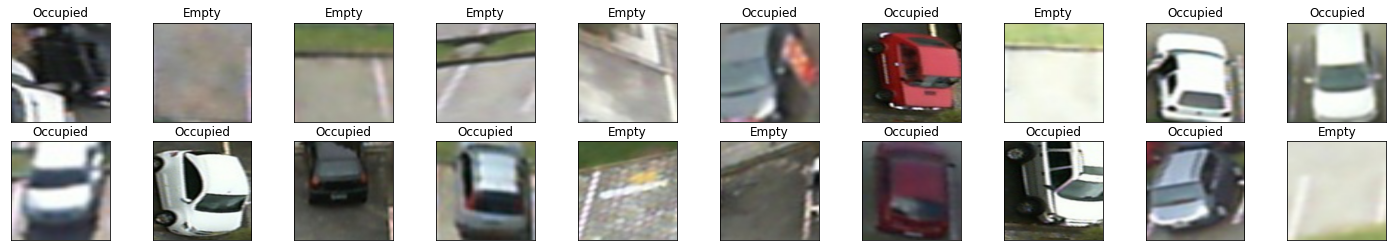

In [3]:
data = './train_validation'
batch_size = 32
num_workers = 1
classes = ["Empty", "Occupied"]

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
data = torchvision.datasets.ImageFolder(data, transform=transform)
# Split into train and validation
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
relevant_indices = [i for i in range(len(data))]
np.random.shuffle(relevant_indices)
split = int(len(data) * 0.66) #split at 66%
# split into training and validation indices
relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
train_sampler = SubsetRandomSampler(relevant_train_indices)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                           num_workers=1, sampler=train_sampler)
val_sampler = SubsetRandomSampler(relevant_val_indices)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                          num_workers=1, sampler=val_sampler)

# Verification Step
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [4]:
print('Length of training dataset: ', len(train_loader.dataset))
print('Length of validation dataset: ', len(val_loader.dataset))
print('Length of testing dataset: ', len(test_loader.dataset))

Length of training dataset:  520845
Length of validation dataset:  520845
Length of testing dataset:  175006


In [5]:
class car_net(nn.Module):
  def __init__(self):
    super(car_net, self).__init__()
    self.name = 'car'
    self.conv1 = nn.Conv2d(3, 5, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 10, 5)
    self.fc1 = nn.Linear(10 * 53 * 53, 32)
    self.fc2 = nn.Linear(32, 2)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 10 * 53 * 53)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

In [6]:
def get_accuracy(model, data_loader, n):
    correct, total, count = 0,0,0
    for imgs, labels in data_loader:
        if count >= n:
            break
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        count += 1
    return correct / total

def training(model, train_loader, val_loader, batch_size=60, num_epochs=5, learn_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    train_acc, val_acc = [], []

    # training
    print ("Training Started...")
    for epoch in range(num_epochs):
        for imgs, labels in itertools.islice(train_loader, 250):
            out = model(imgs)            
            loss = criterion(out, labels) 
            loss.backward()               
            optimizer.step()            
            optimizer.zero_grad()        
            # track accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
        train_acc.append((mini_batch_correct / Mini_batch_total))
        val_acc.append(get_accuracy(model, val_loader, 250))

        print(("Epoch {}: Train Accuracy: {}").format(
                  epoch,
                  train_acc[epoch]))
        print(("Epoch {}: Validation Accuracy: {}").format(
                  epoch,
                  val_acc[epoch]))
        
    return train_acc, val_acc

In [7]:
c_net = car_net()
train_a, val_a = training(c_net, train_loader, val_loader)

Training Started...
Epoch 0: Train Accuracy: 0.9375
Epoch 0: Validation Accuracy: 0.960375
Epoch 1: Train Accuracy: 0.96875
Epoch 1: Validation Accuracy: 0.926125
Epoch 2: Train Accuracy: 0.96875
Epoch 2: Validation Accuracy: 0.98775
Epoch 3: Train Accuracy: 1.0
Epoch 3: Validation Accuracy: 0.989
Epoch 4: Train Accuracy: 1.0
Epoch 4: Validation Accuracy: 0.989375


In [9]:
test = get_accuracy(c_net, test_loader, 250)
print('test accuracy is: ', test)

test accuracy is:  0.982125
